# Interconnect

### Introduction

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

For this project, we will first start with exploring the data, making sure we don't have missing information, keeping only the columns relevant for the model, and creating some extra columns that might help with  getting a deeper understanding of the info.

Then we will proceed with training several models while evaluating their accuracy and ROC-AUC scores in order to select the best model for this task. These all will be evaluated against a random model. Once the best model has been selected, we will proceed with the final test on some part of the data that will be used only for this goal. 

### Initialization

In [1]:
#Importing all necesary libraries and functions
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
#Reading the data
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Exploring the data

We were provided with 4 databases: contract, personal, internet and phone. In this section swe will obtain general information from each one of them and we will perform some exploration on them.

### Contract database

In [3]:
#Getting a first glimpse at the data
display(contract.info())
display(contract.describe(include='all'))
display(contract.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,1293-BSEUN,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,20.2
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


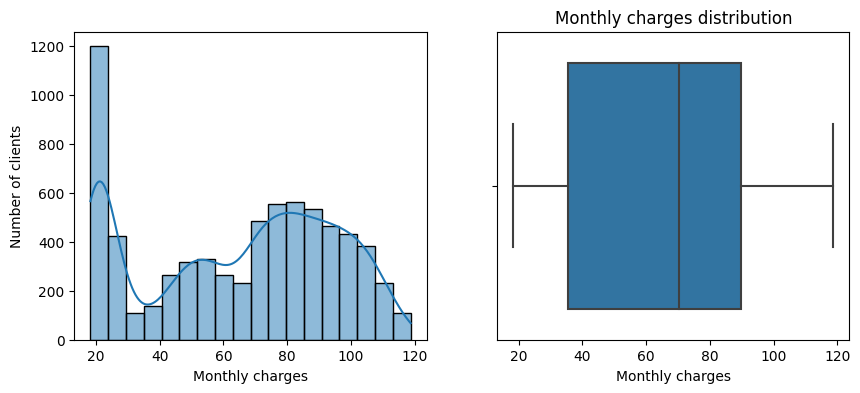

In [4]:

#Analizing the distribution of the MonthlyCharge
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(data=contract, x="MonthlyCharges", kde=True, ax=ax[0])
sns.boxplot(x="MonthlyCharges", data=contract, ax=ax[1]) 
plt.title("Monthly charges distribution")
ax[0].set(xlabel='Monthly charges', ylabel='Number of clients')
ax[1].set_xlabel('Monthly charges')
plt.show()




In [5]:
print('The mean for the Monthly Charges column is', statistics.mean(contract['MonthlyCharges']))
print('The median for the Monthly Charges column is', statistics.median(contract['MonthlyCharges']))
print('The mode for the Monthly Charges column is', statistics.mode(contract['MonthlyCharges']))

The mean for the Monthly Charges column is 64.76169246059918
The median for the Monthly Charges column is 70.35
The mode for the Monthly Charges column is 20.05


In [6]:
#Evaluating class balance
print(len(contract[contract['EndDate']=='No'])/len(contract['EndDate']))

0.7346301292063041


### Findings

This database contains information regarding the client's contracts and its details like start date, payment type and monthly charges.

There are 7043 observations that match the same number of unique client ids. And there are no missing values.

The amount paid by each client per month goes from 18.25 to 118.75. The maximum amount is over 6 times the minimum. This is also relevant because the value that is more present is of 20.05, however, the mean and median are around 65-70. I think this is pointing out to different type of clients. 

Finally, we also discovered that the vast majority of the clients contained in the dataframe are clients who finished the contract. There is a class imbalance that will need to be addressed.

-Preprocessing tasks:

    -Unify the name of the columns to lowercase.
    -Correct data types: BeginDate to date type and TotalCharges to float64.

-Feature engineering tasks:

    -Encode categorical data
    -Obtain year/month from the beginning and end of the contract, to try to identify possible seasonalities. 
    -Define clusters of clients according to the information we have from them and add that information on a new column.
    -Create the target column with only 2 options: ended contract or not.
    -Work on balancing the classes.

### Preprocessing

In [7]:
#Unifying columns headers to lowercase
contract.columns = contract.columns.str.lower()
print(contract.columns)

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')


In [8]:
#Correcting data types

#Converting the 'begindate' to datetime
contract['begindate'] = pd.to_datetime(contract['begindate'], format='%Y-%m-%d')

print("\nDataFrame dtypes after conversion:")
print(contract.dtypes)



DataFrame dtypes after conversion:
customerid                  object
begindate           datetime64[ns]
enddate                     object
type                        object
paperlessbilling            object
paymentmethod               object
monthlycharges             float64
totalcharges                object
dtype: object


In [9]:
#Converting the 'enddate' to datetime
contract['enddate'] = pd.to_datetime(contract['enddate'], format='%Y-%m-%d', errors='coerce')

print("\nDataFrame dtypes after conversion:")
print(contract.dtypes)



DataFrame dtypes after conversion:
customerid                  object
begindate           datetime64[ns]
enddate             datetime64[ns]
type                        object
paperlessbilling            object
paymentmethod               object
monthlycharges             float64
totalcharges                object
dtype: object


In [10]:
#Converting the 'totalcharges' to float64
contract['totalcharges'] = pd.to_numeric(contract['totalcharges'], errors='coerce').fillna(0)

print("\nDataFrame dtypes after conversion:")
print(contract.dtypes)


DataFrame dtypes after conversion:
customerid                  object
begindate           datetime64[ns]
enddate             datetime64[ns]
type                        object
paperlessbilling            object
paymentmethod               object
monthlycharges             float64
totalcharges               float64
dtype: object


In [11]:
#Filtering data of clients that started the contract on 2020-01-01
january = contract[contract['begindate'] == '2020-01-01']
print(january.head(10))

     customerid  begindate enddate            type paperlessbilling  \
0    7590-VHVEG 2020-01-01     NaT  Month-to-month              Yes   
33   7310-EGVHZ 2020-01-01     NaT  Month-to-month               No   
34   3413-BMNZE 2020-01-01     NaT  Month-to-month               No   
70   2273-QCKXA 2020-01-01     NaT  Month-to-month               No   
91   2424-WVHPL 2020-01-01     NaT  Month-to-month               No   
100  6380-ARCEH 2020-01-01     NaT  Month-to-month               No   
101  3679-XASPY 2020-01-01     NaT  Month-to-month               No   
128  3930-ZGWVE 2020-01-01     NaT  Month-to-month               No   
181  6582-OIVSP 2020-01-01     NaT  Month-to-month               No   
199  3645-DEYGF 2020-01-01     NaT  Month-to-month               No   

                 paymentmethod  monthlycharges  totalcharges  
0             Electronic check           29.85         29.85  
33   Bank transfer (automatic)           20.20         20.20  
34   Bank transfer (automatic

After changing the data type to float64, 11 empty values appeared. After revising, it turned out that those values corresponded to contracts starting on 2020-02-01. The information we have doesn't go after that month. For that reason, the total charges haven't been computed yet. It seems like they start being added up after the second month of the contract. This was discovered by filtering the data of clients who started the contract on 2020-01-01 (one month earlier). Said client's 'totalcharges' amount for one month of the montyly charges. As seen on the next box. For this reason, the empty values will be replaced with zeros. 

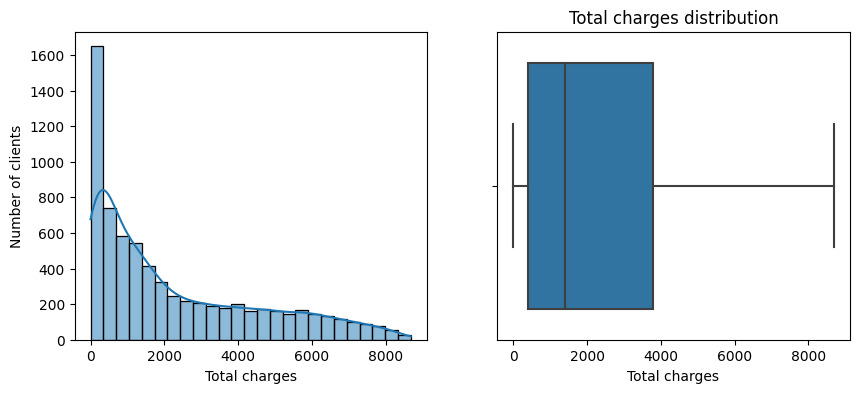

In [12]:
#Analizing the distribution of the totalcharges
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(data=contract, x="totalcharges", kde=True, ax=ax[0])
sns.boxplot(x="totalcharges", data=contract, ax=ax[1]) 
plt.title("Total charges distribution")
ax[0].set(xlabel='Total charges', ylabel='Number of clients')
ax[1].set_xlabel('Total charges')
plt.show()


The distribution shows that most of the clients have paid in total less than 2 thousand, meaning that either they have been clients for a little time and/or pay little amounts.

In [13]:
#Exploring the values in the enddate column
contract['enddate'].value_counts()

2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: enddate, dtype: int64

It is interesting to see that the end dates go only from October 2019 to January 2020. And they are specifically the first day of the month. This probably point to the fact that maybe it doesn't matter when they decide to stop being customers with the company, their contracts end on the first day of the month and that is what is being reflected here. 

But the information we have starts on February 2014 and goes until February 2020. Why do we only have clients ending the contract starting on October 2019. Were the clients not leaving before? Or was the information not being registered? We could discover this by comparing the begin date to the total amount paid. If all clients are still active when there's no end date, the number of months since they started the contract, should match the prorated total charges by the number of months minus one.

If that matches, it would mean that something happened recently that is making the clients leave the company.

### Feature engineering

In [14]:
#Creating a column with the year a contract started
contract['beginyear'] = contract['begindate'].dt.year
print(contract.head())

   customerid  begindate    enddate            type paperlessbilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01        NaT        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01        NaT        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               paymentmethod  monthlycharges  totalcharges  beginyear  
0           Electronic check           29.85         29.85       2020  
1               Mailed check           56.95       1889.50       2017  
2               Mailed check           53.85        108.15       2019  
3  Bank transfer (automatic)           42.30       1840.75       2016  
4           Electronic check           70.70        151.65       2019  


In [15]:
#Creating a column with the month a contract started
contract['beginmonth'] = contract['begindate'].dt.month
print(contract.head())

   customerid  begindate    enddate            type paperlessbilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01        NaT        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01        NaT        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               paymentmethod  monthlycharges  totalcharges  beginyear  \
0           Electronic check           29.85         29.85       2020   
1               Mailed check           56.95       1889.50       2017   
2               Mailed check           53.85        108.15       2019   
3  Bank transfer (automatic)           42.30       1840.75       2016   
4           Electronic check           70.70        151.65       2019   

   beginmonth  
0           1  
1           4  
2          10  
3           5  
4           9  


In [16]:
#Creating a column with the number of months the contract was active/has been active
def calculate_months(df, start_col, end_col):
    """
    Calculates the number of months between a start and end date.

    Args:
        df (pd.DataFrame): The DataFrame containing the dates.
        start_col (str): The name of the column with the start date.
        end_col (str): The name of the column with the end date.

    Returns:
        pd.Series: A Series containing the number of months.
    """
    
    # Define the predefined end date for NaT values
    predefined_end_date = pd.Timestamp('2020-02-01')

    # Replace NaT values in the end date column with the predefined date
    end_col = df[end_col].fillna(predefined_end_date)

    # Calculate the number of months. 
    
    months_delta = (
        end_col.dt.to_period('M').astype(int) - 
        df[start_col].dt.to_period('M').astype(int)
    )

    return months_delta



#Applying the function
contract['contractduration'] = calculate_months(contract, 'begindate', 'enddate')

print(contract.head())



   customerid  begindate    enddate            type paperlessbilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01        NaT        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01        NaT        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               paymentmethod  monthlycharges  totalcharges  beginyear  \
0           Electronic check           29.85         29.85       2020   
1               Mailed check           56.95       1889.50       2017   
2               Mailed check           53.85        108.15       2019   
3  Bank transfer (automatic)           42.30       1840.75       2016   
4           Electronic check           70.70        151.65       2019   

   beginmonth  contractduration  
0           1                 1  
1           4                34  
2          10             

In [17]:
#Creating the target column
contract['contractended'] = (~contract['enddate'].isna()).astype(int)

print(contract.head())

   customerid  begindate    enddate            type paperlessbilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01        NaT        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01        NaT        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               paymentmethod  monthlycharges  totalcharges  beginyear  \
0           Electronic check           29.85         29.85       2020   
1               Mailed check           56.95       1889.50       2017   
2               Mailed check           53.85        108.15       2019   
3  Bank transfer (automatic)           42.30       1840.75       2016   
4           Electronic check           70.70        151.65       2019   

   beginmonth  contractduration  contractended  
0           1                 1              0  
1           4                3

Now that we have the information of the amount of months that each contract has lasted, we can also plot the duration of the contracts up to this point:

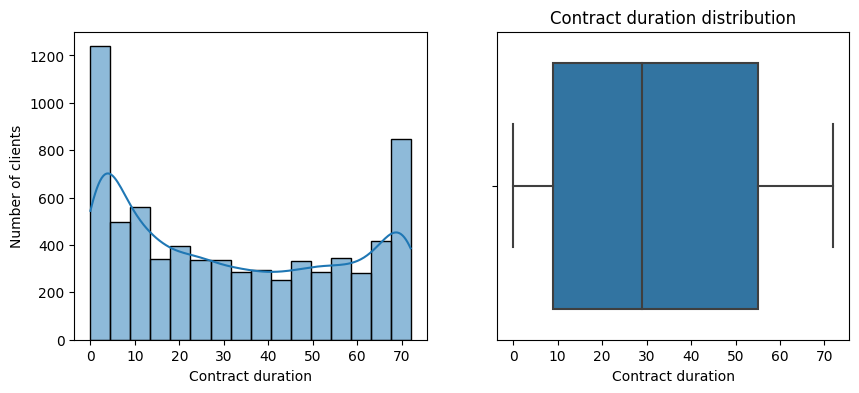

In [18]:


#Analizing the distribution of the contract duration
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(data=contract, x="contractduration", kde=True, ax=ax[0])
sns.boxplot(x="contractduration", data=contract, ax=ax[1]) 
plt.title("Contract duration distribution")
ax[0].set(xlabel='Contract duration', ylabel='Number of clients')
ax[1].set_xlabel('Contract duration')
plt.show()



In [19]:
contract['contractduration'].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: contractduration, dtype: float64

In [20]:
#Obtaining information of new clients that started contract on February 2020
newclients = contract[contract['begindate']== '2020-02-01']
print(len(newclients))


11


In [21]:
#Obtaining information on number of contracts that lasted 0 months
noduration = contract[contract['contractduration']== 0]
print(len(noduration))


11


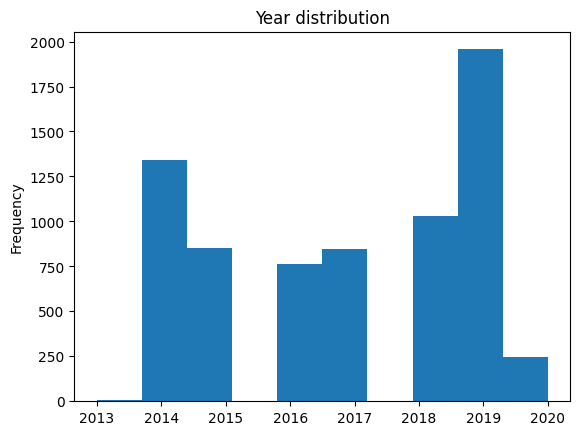

In [22]:

#Plotting the distribution of the year the contract started
contract['beginyear'].plot(kind='hist', title='Year distribution', xlabel='Contract starts')
plt.show()


The average contract on this database, has lasted 32 months. Most of the client's contracts haven't lasted more than 5 months. However, that could be due to them being newer clients. Since also, most contracts started on 2019.

Also, there clients whose contract has lasted 0 months, but in all cases, those clients started the contract on February 2020. 

In [23]:
#Creating a validation series to analyze if contracts ended without being registered on the enddate column
validation=contract['contractduration']-(contract['totalcharges']/contract['monthlycharges']).round()
print(validation.describe())

count    7043.000000
mean        0.003124
std         1.156703
min        -8.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         7.000000
dtype: float64



I am curious to discover if there is a possibility that the clients have been ending their contracts, but it is not shown on the enddate column. For this purpose I created a series that prorates the totalcharges divided by the monthly charges, this number should be equal or close to the contract duration. In order to get an idea of how close the number obtained is actually similar to the contract duration, I subtract the number obtained from the contract duration feature. And I printed the results of applying the describe funciton to this series. The results are showing that while there is at least one case where the duration of the contract difers by 7 months to the prorated result, in general, the mean tends to zero. So it is really close. With this information I would conclude that the information regarding the end of the contracts is accurate, so we don't have clients who left before October 2019. What could be the reason? It seems like something is happening in the market recently, making the clients leave.


### Personal database

In [24]:
display(personal.describe(include='all'))
display(personal.info())
display(personal.head(10))

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,1293-BSEUN,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


### Findings

This database also contains 7043 observations linked to a unique customerID and there is no missing data. All of the features contained in this database are categorical data with only two possible options, however, some of them are expressed as yes/no, other as 0 or 1 and a final one as female/male. The was this information is handled should be made uniformly.

All the information contained on this database is binary. So, the describe method is enough to give us a general idea of the information contained on it: 
- 50% of the clients are female and 50% are male.
- Most of the clients are not Senior Citizens
- 52% of the clients don't have a partner.
- 70% of the client's don't have dependants

Prepocessing tasks: 

-Name of the columns to lowercase 
-Encode categorical data

EDA tasks:

-All the databases will be combined using the customerID information. Once that is done, it will be relevant to analyze the relationship between features.

### Preprocessing

In [25]:
#Unifying columns headers to lowercase
personal.columns = personal.columns.str.lower()
print(personal.columns)

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents'], dtype='object')


At the moment, this is all that will be done with this database. Nor further data engineering will be done. 

### Internet database

In [26]:
display(internet.describe(include='all'))
display(internet.info())
display(internet.head(10))

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,5712-PTIWW,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


### Findings

This database is smaller than the previous ones. With only 5517 observations, all of them corresponding to a unique CustomerID. This would point to the fact that not all the clients have contracted internet services or any of the other services. Except for the customerID, all of the features present on this database, are binary. Including the Internet Service one. It seems like there are only 2 possible options for the internet as well. 

It is notable that the vast majority of the clients have fiber optic service and regarding the extra services, less than 50% of the clients that hired internet services hired each extra service individually. 

Preprocessing tasks:

    -Name of the columns to lowercase.
    -Encode the data 

Feature engineering tasks:

    -When this dataframe is merged with the rest of them, it will be needed to identify clients who haven't hired internet services. It will be identified on the internet service column with a third option that says 'no' if they don't have internet service at all.

### Preprocessing

In [27]:

#Unifying columns headers to lowercase
internet.columns = internet.columns.str.lower()
print(internet.columns)


Index(['customerid', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')


No further actions will be done with this database at this step.

### Phone database

In [28]:
display(phone.describe(include='all'))
display(phone.info())
display(phone.head(10))

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,1293-BSEUN,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


### Findings

This database only adds one more feature that shows whether the client has or not multiple phone lines. This one is also smaller than the first two, pointing out that not every client has hired phone services. 

Preprocessing tasks:

-Name of the columns to lowercase.
-Unify the binary features to be 0 and 1. 

Feature engineering tasks:

-When merging this database to the rest of them, it will be advisable to add another column that simply shows whether a client has hired phone services or not, since the current one shows if it has one or more lines. 


### Preprocessing

In [29]:
#Unifying columns headers to lowercase
phone.columns = phone.columns.str.lower()
print(phone.columns)


Index(['customerid', 'multiplelines'], dtype='object')


### Merging databases

In [30]:
#Merging the contract and personal dataframes
merged_df = pd.merge(contract, personal, on='customerid', how='outer')
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   beginyear         7043 non-null   int64         
 9   beginmonth        7043 non-null   int64         
 10  contractduration  7043 non-null   int64         
 11  contractended     7043 non-null   int64         
 12  gender            7043 non-null   object        
 13  seniorcitizen     7043 non-null   int64         
 14  partner           7043 n

In [31]:
# Merging the new merged_df with the internet dataframe
columns = internet.columns
merged_df = pd.merge(merged_df, internet,  on='customerid', how='outer')
merged_df[columns] = merged_df[columns].fillna('No')
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   beginyear         7043 non-null   int64         
 9   beginmonth        7043 non-null   int64         
 10  contractduration  7043 non-null   int64         
 11  contractended     7043 non-null   int64         
 12  gender            7043 non-null   object        
 13  seniorcitizen     7043 non-null   int64         
 14  partner           7043 n

In the following step we will be merging the entire df with the phone database. While doing that, we will create a feature that simply shows whether a client has hired phone services or not that will be named 'phoneservice', it will be created by comparing with the 'multiplelines' feature. If that column shows either 'yes' or 'no', it means that the client has at least one phone line. So, only clients that as NaN on the 'multiplelines' column, are client with no phone service at all. 

In [32]:
# Merging the new merged_df with the phone dataframe
merged_df = pd.merge(merged_df, phone,  on='customerid', how='outer')
merged_df['phoneservice'] = merged_df['multiplelines'].notna().astype(int)
merged_df['multiplelines'] = merged_df['multiplelines'].fillna('No')
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   beginyear         7043 non-null   int64         
 9   beginmonth        7043 non-null   int64         
 10  contractduration  7043 non-null   int64         
 11  contractended     7043 non-null   int64         
 12  gender            7043 non-null   object        
 13  seniorcitizen     7043 non-null   int64         
 14  partner           7043 n

In [33]:
#Getting a glimpse at the final dataframe
display(merged_df.head())

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,beginyear,beginmonth,...,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,phoneservice
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,2020,1,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,2017,4,...,No,DSL,Yes,No,Yes,No,No,No,No,1
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,2019,10,...,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,2016,5,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,2019,9,...,No,Fiber optic,No,No,No,No,No,No,No,1


Now that the dataframes have been merged into one, there is no use in the model for the customerid column since it is only an identifier. We will get rid of it before moving forward. Also, since we obtained the year and month out of the begin date in a separate column, there is no use in keeping the being date since it has the same information.

In [34]:
#Getting rid of the customerid column
merged_df = merged_df.drop(['customerid', 'begindate'], axis = 1)

### Additional findings

In [35]:
#Creating a dataframe containing only the clients that ended the contract
ended = merged_df[merged_df['contractended']==1]
display(ended.info())
display(ended.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 2 to 7041
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   enddate           1869 non-null   datetime64[ns]
 1   type              1869 non-null   object        
 2   paperlessbilling  1869 non-null   object        
 3   paymentmethod     1869 non-null   object        
 4   monthlycharges    1869 non-null   float64       
 5   totalcharges      1869 non-null   float64       
 6   beginyear         1869 non-null   int64         
 7   beginmonth        1869 non-null   int64         
 8   contractduration  1869 non-null   int64         
 9   contractended     1869 non-null   int64         
 10  gender            1869 non-null   object        
 11  seniorcitizen     1869 non-null   int64         
 12  partner           1869 non-null   object        
 13  dependents        1869 non-null   object        
 14  internetservice   1869 n

None

,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,beginyear,beginmonth,contractduration,contractended,...,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,phoneservice
count,1869,1869,1869,1869,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.0,...,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869.000000
unique,4,3,2,4,NaN,NaN,NaN,NaN,NaN,NaN,...,2,3,2,2,2,2,2,2,2,NaN
top,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN,NaN,NaN,...,No,Fiber optic,No,No,No,No,No,No,No,NaN
freq,485,1655,1400,1071,NaN,NaN,NaN,NaN,NaN,NaN,...,1543,1297,1574,1346,1324,1559,1055,1051,1019,NaN
first,2019-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,74.441332,1531.796094,2017.834671,7.501338,17.979133,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.909042
std,NaN,NaN,NaN,NaN,24.666053,1890.822994,1.566498,3.350129,19.531123,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.287626
min,NaN,NaN,NaN,NaN,18.850000,18.850000,2013.000000,1.000000,1.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,56.150000,134.500000,2017.000000,5.000000,2.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Now that we have a dataframe with all the information, it seemed interesting to check with the describe method if any information pops up when filtering only the clients that ended the contract. At a glimpse, the following cought my attention:

- 88.5% of the clients had a month to month type of contract. 
- 75% of them were enrolled in paperless billing.
- 57% paid via electronic check. 
- 82.5% of them don't have dependents.
- It seems like the vast majority of them didn't hire additional services.

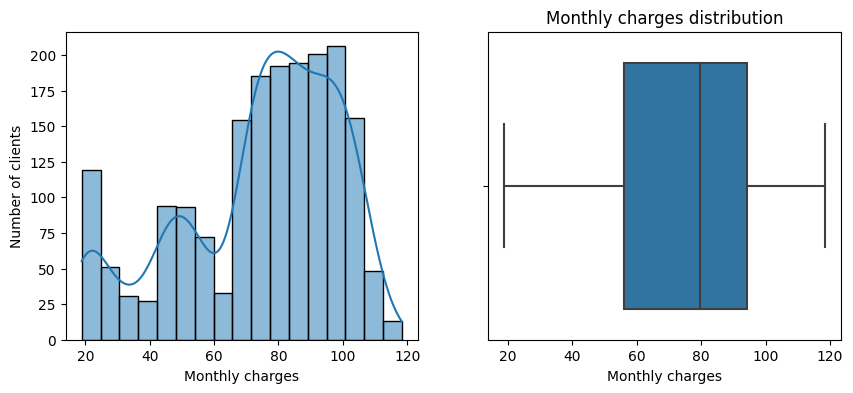

In [36]:
#Analizing the distribution of the MonthlyCharge between clients that ended the contract
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(data=ended, x="monthlycharges", kde=True, ax=ax[0])
sns.boxplot(x="monthlycharges", data=ended, ax=ax[1]) 
plt.title("Monthly charges distribution")
ax[0].set(xlabel='Monthly charges', ylabel='Number of clients')
ax[1].set_xlabel('Monthly charges')
plt.show()

In [37]:
print('The mean for the Monthly Charges column is', statistics.mean(ended['monthlycharges']))
print('The median for the Monthly Charges column is', statistics.median(ended['monthlycharges']))
print('The mode for the Monthly Charges column is', statistics.mode(ended['monthlycharges']))

The mean for the Monthly Charges column is 74.44133226324237
The median for the Monthly Charges column is 79.65
The mode for the Monthly Charges column is 74.4


The client that is ending the contract has an average monthly payment higher than when considering all clients. For all clients the mean monthly charge was of 64.76 while for clients that ended the contract it is of 74.44.
It is also interesting to see that the mode for these clients is of 74.4 while for the entire dataframe it was of 20.05. 
The company is losing the clients with the bigger tickets. 

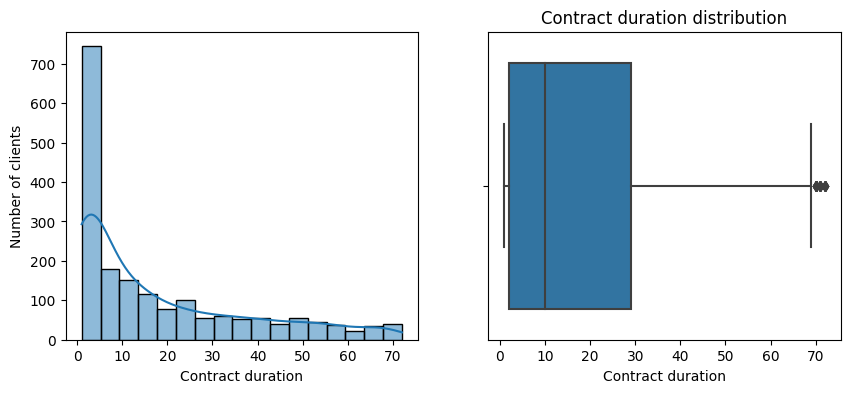

In [38]:
#Analizing the distribution of the contract duration
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(data=ended, x="contractduration", kde=True, ax=ax[0])
sns.boxplot(x="contractduration", data=ended, ax=ax[1]) 
plt.title("Contract duration distribution")
ax[0].set(xlabel='Contract duration', ylabel='Number of clients')
ax[1].set_xlabel('Contract duration')
plt.show()

The average client ending the contract only staying with the company for 10 months, while the entire dataframe showed an average contract duration of around 30 months.

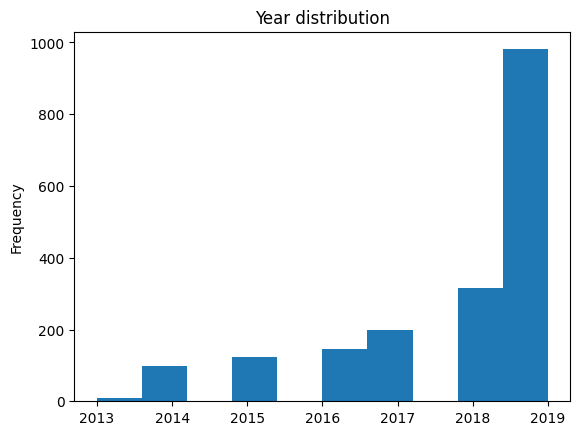

In [39]:
#Plotting the distribution of the year the contract started
ended['beginyear'].plot(kind='hist', title='Year distribution', xlabel='Contract starts')
plt.show()

Also, the clients that are leaving are mostly recent clients that started the contract in the last year. 

Since the clients aren't staying not even a year and 88.5% of them had a month to month type of contract, it seems like it would be advisable to try to push the yearly contract. 

### Splitting the data

The data will be split into 3 sets: training, validation and test set. We will train the model on 60% of the data, then evaluate with 20% and have 20% of the data left to do a final test on the selected model.

In [40]:
#Defining features and target. We are dropping the contractended feature since it will be the target. Also dropping the enddate feature, since it contains the target information as well
features = merged_df.drop(['contractended', 'enddate'], axis = 1)
target = merged_df['contractended']

In [41]:
#Splitting the data
#Obtaining 20% of the total as the training set
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)
#Obtaining 25% from 80% of the total that is now the training set in order to get 20% of the original total.
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=12345, stratify=target_train)

In [42]:
#Validating that the split was done correctly:
print(f"The training set shape is {features_train.shape}")
print(f"The validation set shape is {features_valid.shape}")
print(f"The test set shape is {features_test.shape}")

The training set shape is (4225, 21)
The validation set shape is (1409, 21)
The test set shape is (1409, 21)


### Preparing the training data

Before we can start training the models we still need to encode the categorical features that we have, scale the data and fix the class imbalance on the training data set.

In [43]:
#Applying One Hot encoding to the categorical data
# Specifying the columns to one-hot encode
def encoding(features):
    categorical_cols = ['type', 'paperlessbilling', 'paymentmethod', 'gender', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']
    
    # Initializing the OneHotEncoder
    encoder = OneHotEncoder(sparse=False, drop='first') 
    
    # Fit and transform the specified columns
    encoded_features = encoder.fit_transform(features[categorical_cols])
    
    # Create a DataFrame from the encoded features
    encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(categorical_cols))
    
    #Maintaining the original index
    encoded_features_df.index = features.index 
    
    # Concatenate the encoded DataFrame with the original DataFrame (excluding the original categorical columns)
    features_enc = pd.concat([features.drop(columns=categorical_cols), encoded_features_df], axis=1)

    return features_enc

#Applying the function to the training set features

features_train_enc = encoding(features_train)

#Verifying that all the info in the new features_train_enc has the right type of information

print(features_train_enc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 1398 to 3811
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   monthlycharges                         4225 non-null   float64
 1   totalcharges                           4225 non-null   float64
 2   beginyear                              4225 non-null   int64  
 3   beginmonth                             4225 non-null   int64  
 4   contractduration                       4225 non-null   int64  
 5   seniorcitizen                          4225 non-null   int64  
 6   phoneservice                           4225 non-null   int64  
 7   type_One year                          4225 non-null   float64
 8   type_Two year                          4225 non-null   float64
 9   paperlessbilling_Yes                   4225 non-null   float64
 10  paymentmethod_Credit card (automatic)  4225 non-null   float64
 11  p

All the features are now a numerical type of information. Now that this was done, we will proceed with upsampling the data so that we have a bigger amount of observations showing clients that ended the contract:

In [44]:
#Fixing class imbalance - upsampling
#Defining the upsample funciton
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

#Applying the function
features_upsampled, target_upsampled = upsample(
    features_train_enc, target_train, 10)

#Validating the results by obtaining the shape of the new training data:
print(f"The features_upsampled set shape is {features_upsampled.shape}")
print(f"The target_upsampled set shape is {target_upsampled.shape}")

The features_upsampled set shape is (14314, 25)
The target_upsampled set shape is (14314,)


In [45]:
#Scaling the data
def scaling(features):
    scaler = StandardScaler() 
    features_scaled = scaler.fit_transform(features)
    return features_scaled

#Applying the scaling function to the features_upsampled set
features_upsampled = scaling(features_upsampled)
print(features_upsampled[0:4])
   

[[ 1.01850021 -0.17196106  0.26712629  0.5423725  -0.3391279  -0.54629641
   0.3168592  -0.37865824 -0.30932635  0.64289162  2.31433098 -1.0101112
  -0.45979154 -1.00167809 -0.80647958 -0.52664164  0.77531837 -0.34518921
   2.00078628  1.51797479 -0.65212831 -0.50645413  1.1643995   1.13186375
  -0.89825773]
 [-1.91505736 -0.13891149 -2.024197   -1.4748747   2.23769207 -0.54629641
   0.3168592  -0.37865824  3.23283158 -1.55547213 -0.43209031 -1.0101112
  -0.45979154  0.99832472  1.239957    1.8988244  -1.28979274  2.89696193
  -0.49980351 -0.65877247 -0.65212831 -0.50645413 -0.85881177 -0.88349857
  -0.89825773]
 [-0.25295848  0.10671523 -0.30570453 -1.18669653  0.38418999 -0.54629641
   0.3168592  -0.37865824 -0.30932635 -1.55547213  2.31433098 -1.0101112
  -0.45979154 -1.00167809 -0.80647958 -0.52664164 -1.28979274 -0.34518921
   2.00078628 -0.65877247  1.53344056  1.97451248 -0.85881177 -0.88349857
   1.11326623]
 [-1.94886276 -0.86205168  0.83995711  0.83055067 -0.97203105 -0.54629

The features_upsampled is now ready. All the info is numerical, the positive results in the target were upsampled, and the data was scaled to avoid giving more importance to one feature over another.

Additionally, we are going to scale the the features_train_enc set, since it is the same training set with the encoding but no upsampling. This set will be used when we are using the parameters of the models themselves to deal with the class imbalance.

In [46]:
#Applying the scaling function to the features_train_enc set
features_train_enc = scaling(features_train_enc)
print(features_train_enc[0:4])

[[ 0.6525318  -0.15345467  0.57634469 -1.23088184 -0.34664974 -0.4414215
   0.33003619 -0.50184844 -0.56268067  0.82133656 -0.52760412  1.40249577
  -0.54187762 -1.02954881 -0.97498727 -0.65963799  1.12923647 -0.52467057
   1.5748748  -0.72703629 -0.71755131  1.56043563 -0.79254717 -0.80726761
   1.18000518]
 [-1.31002773 -0.42245636 -0.9532133   1.00576168  0.79622592 -0.4414215
   0.33003619 -0.50184844  1.77720696 -1.21752769  1.89536047 -0.71301463
  -0.54187762  0.97129927 -0.97498727  1.51598302 -0.88555411  1.90595788
  -0.63497111 -0.72703629 -0.71755131 -0.64084669 -0.79254717 -0.80726761
   1.18000518]
 [-1.50210803 -0.66770229  0.06649203 -1.51046228  0.1839711  -0.4414215
   0.33003619 -0.50184844  1.77720696 -1.21752769 -0.52760412 -0.71301463
   1.84543514 -1.02954881 -0.97498727 -0.65963799 -0.88555411  1.90595788
  -0.63497111 -0.72703629 -0.71755131 -0.64084669 -0.79254717 -0.80726761
  -0.84745391]
 [ 0.35188438 -0.98365839  1.08619736  1.56492256 -1.28544047  2.26540

### Preparing the validation set

In [47]:
#Encoding the features of the validation set
features_valid_enc = encoding(features_valid)
print(features_valid_enc.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 2018 to 988
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   monthlycharges                         1409 non-null   float64
 1   totalcharges                           1409 non-null   float64
 2   beginyear                              1409 non-null   int64  
 3   beginmonth                             1409 non-null   int64  
 4   contractduration                       1409 non-null   int64  
 5   seniorcitizen                          1409 non-null   int64  
 6   phoneservice                           1409 non-null   int64  
 7   type_One year                          1409 non-null   float64
 8   type_Two year                          1409 non-null   float64
 9   paperlessbilling_Yes                   1409 non-null   float64
 10  paymentmethod_Credit card (automatic)  1409 non-null   float64
 11  pa

In [48]:
#Scaling the features on the validation set
features_valid_enc = scaling(features_valid_enc)
print(features_valid_enc[0:4])


[[-0.60919781 -0.96734944  1.06635586  0.98534661 -1.26124848 -0.45651375
   0.33346475 -0.51570136 -0.58472623  0.86495026 -0.50354614 -0.68501007
   1.71984452 -0.94138808 -0.94676612 -0.61645729 -0.86244529 -0.54536385
  -0.64283724 -0.72791404 -0.7336277  -0.63732851 -0.78947571 -0.7566668
  -0.85869743]
 [ 0.55010202 -0.80718635  1.06635586 -0.42186338 -1.1010737  -0.45651375
   0.33346475 -0.51570136 -0.58472623  0.86495026 -0.50354614  1.45983256
  -0.58144791  1.06226117 -0.94676612 -0.61645729  1.15949384 -0.54536385
  -0.64283724 -0.72791404 -0.7336277  -0.63732851  1.26666342 -0.7566668
  -0.85869743]
 [-0.47947446 -0.94753723  1.06635586  0.98534661 -1.22120478  2.19051453
   0.33346475 -0.51570136 -0.58472623  0.86495026 -0.50354614  1.45983256
  -0.58144791  1.06226117 -0.94676612 -0.61645729 -0.86244529 -0.54536385
   1.55560371 -0.72791404 -0.7336277  -0.63732851 -0.78947571 -0.7566668
  -0.85869743]
 [-1.26602491 -0.95331219  1.06635586  0.98534661 -1.18116109  2.19051

Now that both the training and validation set are ready, we can proceed with training the models.

### Training a Dummy model for a Sanity check

As a first model, we are creating a dummy model that predicts the classes randomly. So that the performance of the rest of the models can be compared to the random model's one.

In [49]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(features_upsampled, target_upsampled)
predictions = dummy_clf.predict(features_valid_enc)

For this entire project, we will be using both the accuracy score and the ROC-AUC one. In order to avoid code repetition, I created a score function that can be used to evaluate every model.

Accuracy Score: 0.49396735273243436
The AUC-ROC score is 0.5


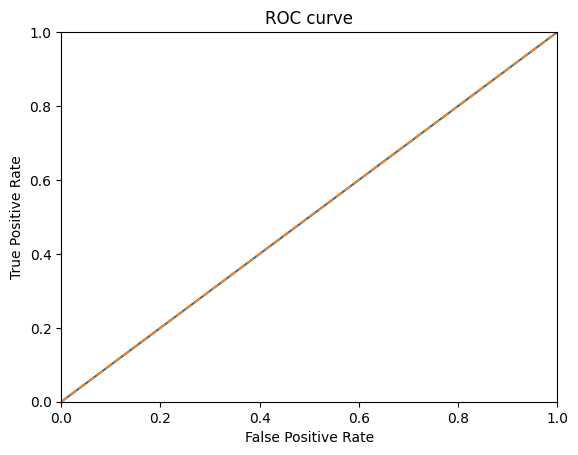

In [50]:
#Creating the score function
def score(features_valid, target_valid, predictions, model):
    accuracy = accuracy_score(target_valid, predictions)
    print(f"Accuracy Score: {accuracy}")

    #Obtaining the ROC-AUC score
    probabilities = model.predict_proba(features_valid)
    probabilities_one = probabilities[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one)
    print('The AUC-ROC score is', auc_roc)

    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one)

    #Plotting the graph
    plt.figure()
    plt.plot(fpr, tpr)
    # ROC curve 
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('ROC curve')
    plt.show()

#Obtaining the scores for the Dummy model

score(features_valid_enc, target_valid, predictions, dummy_clf)

    

The ROC curve shows us if a model is predicting more true positives or false positives. A random model for a binary classification task, is expected to predict 50% of the answers correctly. For that reason the line in the middle of the graph is overlapping with the one generated by the model. This model is behaving exactly as a random model should.

We shoud se a curve towards the top of the graph for the next models, that will show us that the model is behaving better than the Dummy one.

### Decision tree

Accuracy Score: 0.7246273953158269
The AUC-ROC score is 0.7092497868712703


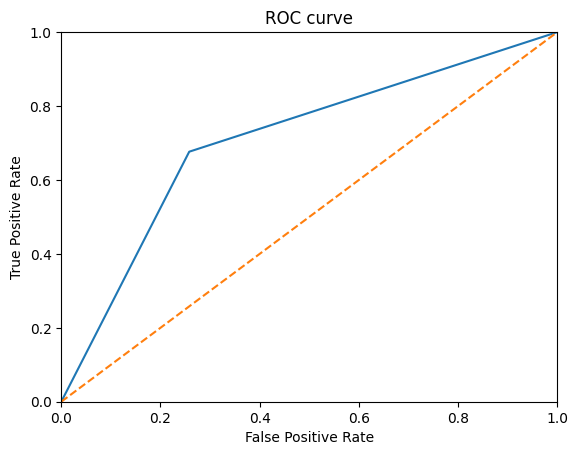

In [51]:
#Training a decision tree model
dtc = DecisionTreeClassifier(random_state=12345)
dtc.fit(features_upsampled, target_upsampled)
predicted_valid=dtc.predict(features_valid_enc)
score(features_valid_enc, target_valid, predicted_valid, dtc)

As expected, the Decision Tree is already getting a better score than the Dummy model. We have an AUC-ROC of 70.92 and an accuracy score of 72.4. This is way better than the 50 score of the random model. However, it is still far from a good model. 

### Random forest

In [52]:
#Training a Random Forest Classifier on the upsampled data
#Defining a random forest function
def r_forest(features_upsampled, features_valid, target_upsampled, target_valid):
    best_score=0
    best_est = 0
    best_depth = 0
    best_model = None
   
    for est in range(10, 101, 10):
        for depth in range(1, 21, 1):
            model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
            model.fit(features_upsampled, target_upsampled)
            predictions_train = model.predict(features_upsampled)
            predicted_valid = model.predict(features_valid)
            score = accuracy_score(target_valid, predicted_valid)
            if score > best_score:
                best_score = score
                best_est = est
                best_depth = depth
                best_model = model
            
        return best_score, best_est, best_depth, best_model, predicted_valid

#Applying the function
best_score, best_est, best_depth, best_model, predicted_valid =r_forest(features_upsampled, features_valid_enc, target_upsampled, target_valid)
print('Accuracy score of the best model on the validation set on the upsampled data:', best_score, 'n_estimators:', best_est, 'best_depth:', best_depth)

Accuracy score of the best model on the validation set on the upsampled data: 0.7821149751596878 n_estimators: 10 best_depth: 17


Accuracy Score: 0.7785663591199432
The AUC-ROC score is 0.828964840218037


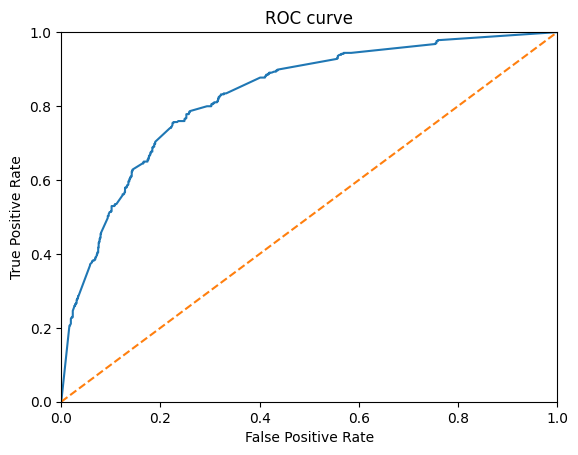

In [53]:

#Obtaining the score
score(features_valid_enc, target_valid, predicted_valid, best_model)


In [54]:
#Defining a random forest function considering the 'class_weight' parameter
def r_forest(features_train, features_valid, target_train, target_valid):
    best_score=0
    best_est = 0
    best_depth = 0
    best_model = None
   
    for est in range(10, 101, 10):
        for depth in range(1, 21, 1):
            model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
            model.fit(features_train, target_train)
            predictions_train = model.predict(features_train)
            predicted_valid = model.predict(features_valid)
            score = accuracy_score(target_valid, predicted_valid)
            if score > best_score:
                best_score = score
                best_est = est
                best_depth = depth
                best_model = model
            
        return best_score, best_est, best_depth, best_model, predicted_valid
    
#Applying the function   
best_score, best_est, best_depth, best_model, predicted_valid=r_forest(features_train_enc, features_valid_enc, target_train, target_valid)
print('Accuracy score of the best model on the validation set:', best_score, 'n_estimators:', best_est, 'best_depth:', best_depth)

Accuracy score of the best model on the validation set: 0.829666430092264 n_estimators: 10 best_depth: 13


Accuracy Score: 0.8048261178140526
The AUC-ROC score is 0.8677245601798033


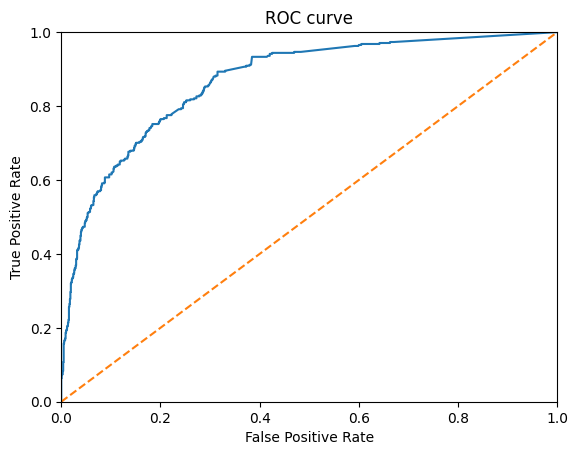

In [55]:
#Obtaining the score
score(features_valid_enc, target_valid, predicted_valid, best_model)

We trained two different Random Forest models. One using the upsampled database and another one using the class weight parameter of the model itself. Out of these two, we obtained a better result with the one that used the class weight parameter. It got a 86.77 AUC-ROC score, vs 82.89 of the other model.

### Linear regression

Accuracy Score: 0.40667139815471964
The AUC-ROC score is 0.9838952181663179


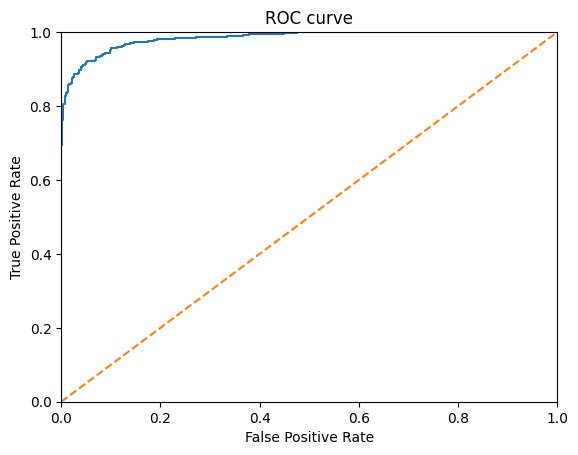

In [56]:
#Training the model on the upsampled set
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid_enc)
score(features_valid_enc, target_valid, predicted_valid, model)

Accuracy Score: 0.914833215046132
The AUC-ROC score is 0.9725826035288951


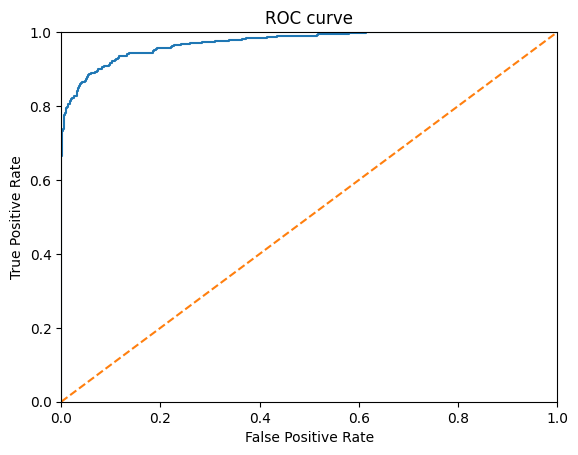

In [57]:
#Training the model with the 'class_weight' parameter
model_cw = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_cw.fit(features_train_enc, target_train)
predicted_valid = model_cw.predict(features_valid_enc)
score(features_valid_enc, target_valid, predicted_valid, model_cw)

We also trained two models for using the Logistic regression models. One with the upsampled training set, and another one using the class weight parameter to account for the class imbalance. Even though the AUC-ROC score seems to be better using the upsampled set, the accuracy score is behaving below the results obtained with the Dummy model. While the model trained using the class weight parameter, is giving a great result: 91.48 for the accuracy score and 97.25 on the AUC-ROC. These are great results. 

### Nearest neighbors

In [58]:

#Defining the k_pred function that runs through the k values of 1 - 10, and returns the accuracy score for each one, selecting the best performance
def k_pred(features_train, features_valid, target_train, target_valid):
    best_score=0
    best_k=0

    for k in range(1, 11, 1):
        model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        score = accuracy_score(target_valid, predicted_valid)
        print(f'Accuracy score: {score:.2f}', 'for', k, 'neighbors')
        if score > best_score:
            best_score = score
            best_k = k
    print(f'Accuracy score of the best model on the validation set: {best_score:.2f}', 'n_neighbors:', best_k )
    return best_score, best_k, predicted_valid



In [59]:

#Applying the model on the upsampled set
best_score, best_k, predicted_valid = k_pred(features_upsampled, features_valid_enc, target_upsampled, target_valid)


Accuracy score: 0.71 for 1 neighbors
Accuracy score: 0.71 for 2 neighbors
Accuracy score: 0.66 for 3 neighbors
Accuracy score: 0.66 for 4 neighbors
Accuracy score: 0.63 for 5 neighbors
Accuracy score: 0.63 for 6 neighbors
Accuracy score: 0.58 for 7 neighbors
Accuracy score: 0.58 for 8 neighbors
Accuracy score: 0.55 for 9 neighbors
Accuracy score: 0.55 for 10 neighbors
Accuracy score of the best model on the validation set: 0.71 n_neighbors: 1


In [60]:
#Applying the model on the set that isn't upsampled
best_score, best_k, predicted_valid = k_pred(features_train_enc, features_valid_enc, target_train, target_valid)


Accuracy score: 0.73 for 1 neighbors
Accuracy score: 0.75 for 2 neighbors
Accuracy score: 0.76 for 3 neighbors
Accuracy score: 0.78 for 4 neighbors
Accuracy score: 0.78 for 5 neighbors
Accuracy score: 0.79 for 6 neighbors
Accuracy score: 0.79 for 7 neighbors
Accuracy score: 0.79 for 8 neighbors
Accuracy score: 0.79 for 9 neighbors
Accuracy score: 0.80 for 10 neighbors
Accuracy score of the best model on the validation set: 0.80 n_neighbors: 10


In [61]:
#Adjusting the function to consider the hyperparameter weights selecting the 'distance' option
def k_pred_d(features_train, features_valid, target_train, target_valid):
    best_score=0
    best_k=0

    for k in range(1, 11, 1):
        model = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='distance')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        score = accuracy_score(target_valid, predicted_valid)
        print(f'Accuracy score: {score:.2f}', 'for', k, 'neighbors')
        if score > best_score:
            best_score = score
            best_k = k
    print(f'Accuracy score of the best model on the validation set: {best_score:.2f}', 'n_neighbors:', best_k )
    return best_score, best_k, predicted_valid



In [62]:
#Applying the adjusted model on the set that isn't upsampled
best_score, best_k, predicted_valid = k_pred_d(features_train_enc, features_valid_enc, target_train, target_valid)


Accuracy score: 0.73 for 1 neighbors
Accuracy score: 0.73 for 2 neighbors
Accuracy score: 0.75 for 3 neighbors
Accuracy score: 0.76 for 4 neighbors
Accuracy score: 0.77 for 5 neighbors
Accuracy score: 0.78 for 6 neighbors
Accuracy score: 0.78 for 7 neighbors
Accuracy score: 0.78 for 8 neighbors
Accuracy score: 0.79 for 9 neighbors
Accuracy score: 0.79 for 10 neighbors
Accuracy score of the best model on the validation set: 0.79 n_neighbors: 10


The best results were obtained using the set that wasn't upsampled and not using the weights parameter. However, the accuracy score is of 80, much lower than the previous one.

### CatBoost Classifier

In [63]:
#Tunning with GridSearchCV

model = CatBoostClassifier(verbose=0)
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.1],
    'iterations': [100, 200]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc')
grid_search.fit(features_train_enc, target_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best score on training set:", best_score)


Best Parameters: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best score on training set: 0.9857265299761794


Accuracy Score: 0.9190915542938254
The AUC-ROC score is 0.9332739156268566


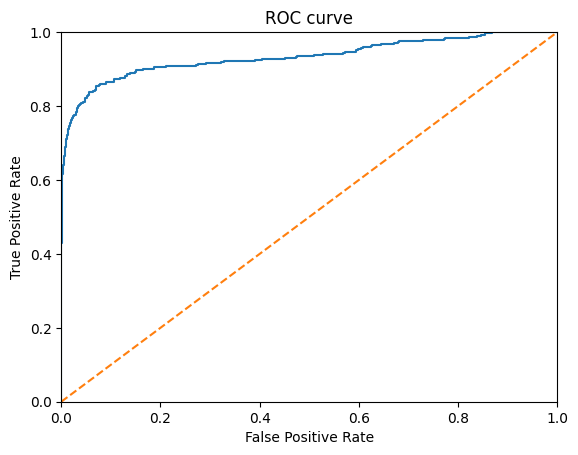

In [64]:
#Applying the best parameters from the GridSearchCV on the CatBoostClassifier, to the validation set
pred_valid = best_model.predict(features_valid_enc)
score(features_valid_enc, target_valid, pred_valid, best_model)

We tuned a CatBoost classifier with GridSearch CV, with this model, we are obtaining 93.3 AUC-ROC and 91.9 accuracy score. These are great scores, however, the logistic regression model is still behaving better.

### XGBClassifier

In [65]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', 
                                  n_estimators=100, learning_rate=0.1, max_depth=5, scale_pos_weight=4)
xgb_model.fit(features_train_enc, target_train)

/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Accuracy Score: 0.8665720369056068
The AUC-ROC score is 0.9189800821514376


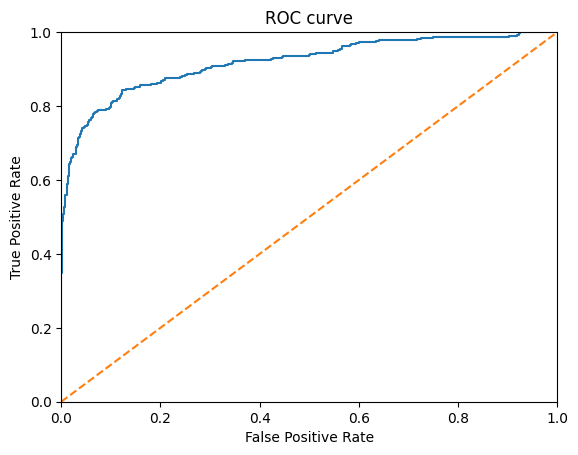

In [66]:
predicted_valid = xgb_model.predict(features_valid_enc)
score(features_valid_enc, target_valid, predicted_valid, xgb_model)

As a final model, we also trained an XGB Classifier, the results are a little lower than the ones obtained with the CatBoost classifier and the logistic regression. 

### Final test

The model with the best performance was the Logistic Regression using the set that wasn't upsampled and using the class weight parameter to account for the class imbalance. This is the model that will be tried on the final test. 

In [67]:
#Preparing the test data by encoding and scaling
features_test_enc = encoding(features_test)
print(features_test_enc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 6095 to 315
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   monthlycharges                         1409 non-null   float64
 1   totalcharges                           1409 non-null   float64
 2   beginyear                              1409 non-null   int64  
 3   beginmonth                             1409 non-null   int64  
 4   contractduration                       1409 non-null   int64  
 5   seniorcitizen                          1409 non-null   int64  
 6   phoneservice                           1409 non-null   int64  
 7   type_One year                          1409 non-null   float64
 8   type_Two year                          1409 non-null   float64
 9   paperlessbilling_Yes                   1409 non-null   float64
 10  paymentmethod_Credit card (automatic)  1409 non-null   float64
 11  pa

In [68]:
features_test_enc = scaling(features_test_enc)
print(features_test_enc[0:4])


[[-1.52071354 -0.96202306  1.05889706  0.99838662 -1.14707573 -0.41850443
   0.31338048 -0.54974368 -0.54207709  0.8206075  -0.53878849 -0.73134013
   1.9349697   0.97962554 -0.96169818 -0.67496556 -0.90966849  1.96008275
  -0.62194133 -0.71880777 -0.7336277  -0.63732851 -0.78356544 -0.80256299
  -0.86997578]
 [ 0.281519    0.70214504 -0.97863924  0.99838662  0.82774928 -0.41850443
   0.31338048  1.81902955 -0.54207709 -1.21860938  1.85601588 -0.73134013
  -0.51680396 -1.02079821 -0.96169818 -0.67496556 -0.90966849 -0.51018254
   1.60786869 -0.71880777  1.3630892   1.56904954  1.27621759 -0.80256299
   1.14945729]
 [ 1.34926303  1.79302009 -0.97863924 -1.49728473  1.19802897 -0.41850443
   0.31338048 -0.54974368 -0.54207709  0.8206075  -0.53878849  1.36735283
  -0.51680396  0.97962554  1.03982728 -0.67496556  1.09930157 -0.51018254
   1.60786869  1.39119253 -0.7336277  -0.63732851  1.27621759  1.24600812
   1.14945729]
 [ 0.16048591 -0.96080008  1.56828114 -1.49728473 -1.27050229 -0.41

Accuracy Score: 0.9020581973030518
The AUC-ROC score is 0.9749050608385648


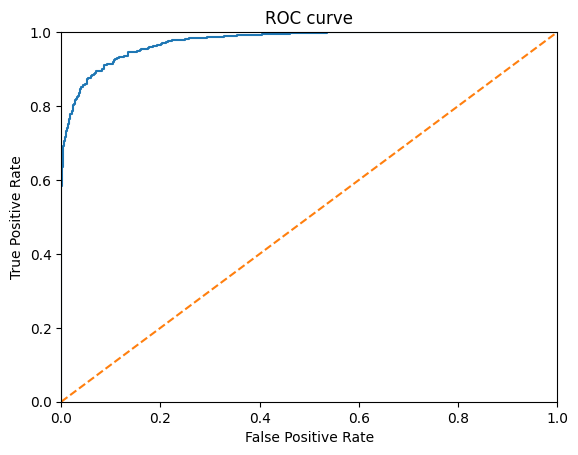

In [69]:
#Applying the LogisticRegression model with the 'class_weight' parameter
predicted_test = model_cw.predict(features_test_enc)
score(features_test_enc, target_test, predicted_test, model_cw)

We obtained a 97.4 AUC-ROC score on the test set, and a 90.2 accuracy score. This is a very good result. For this reason, we can conclude that the Logistic Regression model with the class weight parameter is the best one for this task. 

### Conclusions

The best model for this task is the Logistic Regression model with the following parameters: solver='liblinear', class_weight='balanced'.

We obtained the best results on the validation and test sets with this model.

While performing the EDA some relevant information was also discovered: the clients have only being leaving recently-since October 2019,it seems like there is something going on in the market that is attracting them somewhere else. Most of the client that are leaving haven't been an entire year with the company. Most of them have a month to month type of contract - 82.5%. It would be advisable to consider this information for the marketing strategy.